# Bibliotecas

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Dataframe dos resultados

In [17]:
path = "/home/lucas/experimentos/Transformer_Torch_V2_Normal/version_3/metrics.csv"

df = pd.read_csv(path)
df

,loss,epoch,step,val_loss
0,1.311386e+14,0,49,NaN
1,NaN,0,94,2.672622e+17
2,2.718393e+18,1,99,NaN
3,1.878957e+16,1,149,NaN
4,NaN,1,189,9.565492e+14
...,...,...,...,...
180,2.293691e+12,62,5949,NaN
181,NaN,62,5984,5.073724e+10
182,2.273988e+12,63,5999,NaN
183,2.097497e+12,63,6049,NaN


# 2. Obtendo a loss de treino e de validacao

## 2.1 Validacao

In [18]:
#df_val_loss = df[df['val_loss'].apply(lambda x: pd.notna(x))].copy()
df_val_loss = df[["epoch","val_loss"]].copy()
df_val_loss.rename({"val_loss":"loss"},inplace=True,axis=1)
df_val_loss["Split"] = "Validação"

df_val_loss = df_val_loss[df_val_loss.loss.apply(lambda x: pd.notna(x))]
df_val_loss

,epoch,loss,Split
1,0,2.672622e+17,Validação
4,1,9.565492e+14,Validação
7,2,1.621626e+14,Validação
10,3,7.438780e+13,Validação
13,4,4.981696e+13,Validação
...,...,...,...
173,59,6.442125e+10,Validação
175,60,7.479778e+10,Validação
178,61,5.544451e+10,Validação
181,62,5.073724e+10,Validação


## 2.2 Treino

In [19]:
#index_val = df_val_loss.index.tolist()

#index_val = [x - 1 for x in index_val]
#df_train_loss = df.loc[index_val].copy()
df_train_loss = df[["epoch","loss"]].copy()

df_train_loss["Split"] = "Treino"
df_train_loss

,epoch,loss,Split
0,0,1.311386e+14,Treino
1,0,NaN,Treino
2,1,2.718393e+18,Treino
3,1,1.878957e+16,Treino
4,1,NaN,Treino
...,...,...,...
180,62,2.293691e+12,Treino
181,62,NaN,Treino
182,63,2.273988e+12,Treino
183,63,2.097497e+12,Treino


# 3. Grafico comparativo de Loss

In [20]:
df_concat = pd.concat([df_train_loss,df_val_loss])

In [21]:
df_concat["loss"] = np.log(df_concat["loss"])

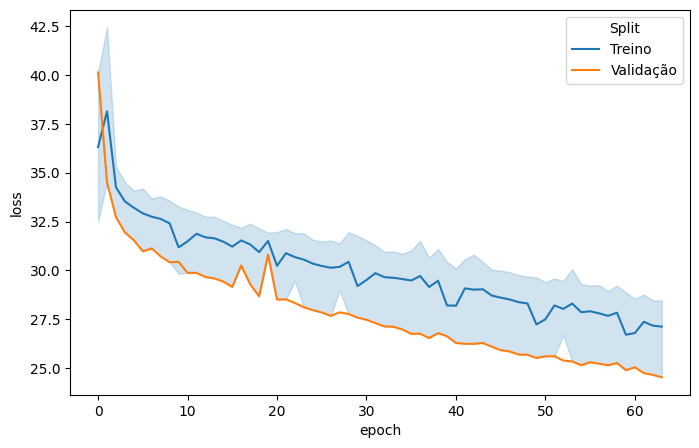

In [22]:
fig, ax = plt.subplots(figsize=(8,5))

sns.lineplot(data=df_concat,x="epoch",y="loss",hue="Split",ax=ax)

#sns.lineplot(data=df,x="epoch",y="loss",ax=ax)
#sns.lineplot(data=df,x="epoch",y="val_loss",ax=ax)
plt.show()

In [23]:
import yaml
from yaml.loader import SafeLoader

with open("/home/lucas/experimentos/Transformer_Torch_V2_Normal/version_3/hparams.yml","r") as infile:
    load = yaml.load(infile,Loader=SafeLoader)
    infile.close()

load

{'dataset': {'batch_size': 32,
  'dataframe': '/home/lucas/Image-Denoising/dataframes/dataframe_v1.csv',
  'num_workers': 8,
  'transformation': 'get_transform_v2()'},
 'name_exp': 'Transformer_Torch_V2_Normal',
 'train': {'dir_save_logs': '/home/lucas/experimentos/',
  'epochs': 64,
  'loss': {'model': 'MSELossPatchEinops(patch_size=14)'},
  'model': 'VisionModelTransformerTorchV2(img_size=(batch_size,3,224,224), patch_size=14, token_len=512, embed_dim=512, num_heads=8, num_layers=6)',
  'name_to_save': 'checkpoint-{epoch:02d}-{val_loss:.10f}',
  'noise': {'model': 'AddNoise()'},
  'optim': {'model': 'torch.optim.Adam(model.parameters(),lr=0.01)'},
  'patience': 30,
  'top_k': 1,
  'train_module': 'TrainModule(model,loss_fn,optimizer)'}}

# 4. Load Model

In [10]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"]="1"

import sys
sys.path.append("/home/lucas/Image-Denoising/src")


import pandas as pd
from PIL import Image
from tqdm import tqdm

from models import VisionModelTransformerTorchV2 as VisionModel
from noises import add_noise
from dataset import CustomImageDataset

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader
from modules.train_module import TrainModule
from torchvision.transforms import v2

from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import EarlyStopping
from lightning.pytorch import Trainer

/home/lucas/miniconda3/envs/image-denoising/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/lucas/miniconda3/envs/image-denoising/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c106detail23torchInternalAssertFailEPKcS2_jS2_RKSs'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [11]:
class AddNoise(torch.nn.Module):
    def forward(self, img, noise,**kwargs):
        noisy_image = add_noise(img, noise_type=noise,**kwargs)

        return Image.fromarray(noisy_image)

batch_size = 16
num_workers = 8
lr = 0.001

noise = AddNoise()
transform = v2.Compose([
    v2.PILToTensor(),
    v2.ToDtype(torch.float32, scale=True)
])

path = "/home/lucas/Image-Denoising/dataframes/dataframe_v1.csv"
df = pd.read_csv(path)

val = df[df["split"] == 'val']
train = df[df["split"] == 'train']

val_dataset = CustomImageDataset(val,transform,noise)
train_dataset = CustomImageDataset(train,transform,noise)


custom_dataloader_val = DataLoader(
    val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False)


custom_dataloader_train = DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False)



model = VisionModel(img_size=(batch_size,3,224,224), patch_size=14, token_len=512, embed_dim=512, num_heads=8, num_layers=6)

model = model.cpu()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=lr)

model = TrainModule.load_from_checkpoint(
    "/home/lucas/experimentos/Transformer_Torch_V2_Normal/version_4/checkpoint-epoch=62-val_loss=172914.6406250000.ckpt",
    map_location={"cuda:0":"cpu","cuda:1":"cpu","cuda":"cpu"},
    model=model,
    loss=loss_fn,
    optim=optimizer
)

/home/lucas/miniconda3/envs/image-denoising/lib/python3.11/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


# 5 Testando inferencias

In [12]:
i = 0
stop = 4
for ori_img, noi_img in custom_dataloader_val:
    if(i == stop):
        break
    i+=1

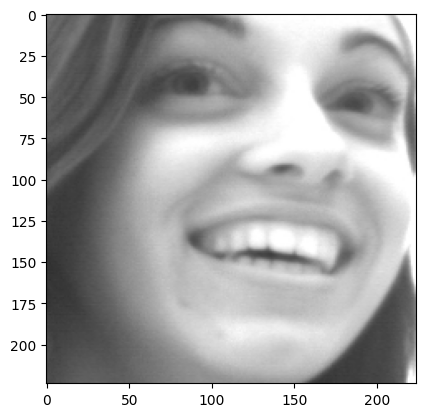

In [13]:
plt.imshow(ori_img[0].permute(1,2,0).detach().numpy())

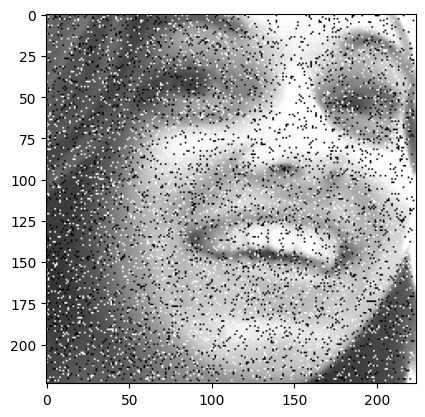

In [14]:
plt.imshow(noi_img[0].permute(1,2,0).detach().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.07586266..1.1749604].


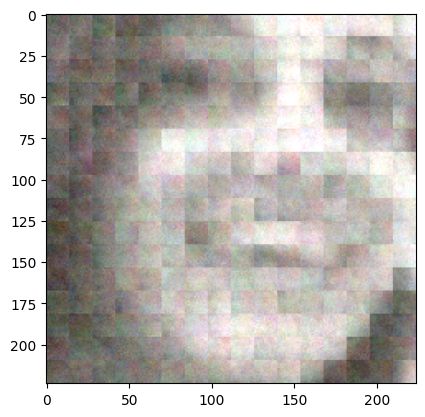

In [15]:
from models.tokenization import UnPatchTokenizationEinops

denoised = model.model(noi_img)
un_patch = UnPatchTokenizationEinops(14,224)
denoised = un_patch(denoised)
plt.imshow(denoised[0].permute(1,2,0).detach().numpy())

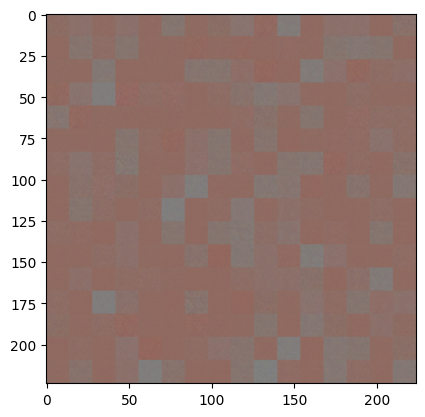

In [15]:
denoised_ = model.model.unpatch_tokenization(denoised[:,:-1,:])
plt.imshow(denoised_[0].permute(1,2,0).detach().numpy())

In [19]:
ori_img_ = model.model.patch_tokenization(ori_img)
denoised_ = model.model.patch_tokenization(denoised_)

In [20]:
denoised_.shape

torch.Size([2, 256, 512])

In [21]:
ori_img_.shape

torch.Size([2, 256, 512])

In [22]:
loss = nn.MSELoss(reduction='none')
loss = loss(denoised_,ori_img_)

In [27]:
torch.sum(loss,dim=-1).sum()

tensor(0.2339, grad_fn=<SumBackward0>)

In [41]:
torch.sum(loss,dim=-1).sum()/2

tensor(0.0484, grad_fn=<DivBackward0>)

In [33]:
denoised.shape

torch.Size([2, 257, 588])

In [55]:

#ori_img_ = model.model.linear(ori_img_)

In [56]:
ori_img_.shape

torch.Size([2, 256, 512])

In [58]:
denoised_.shape

torch.Size([2, 3, 224, 224])

In [59]:
denoised_ = model.model.patch_tokenization(denoised_)
denoised_.shape

torch.Size([2, 256, 512])

In [60]:
loss = nn.MSELoss(reduction='none')
loss = loss(denoised_,ori_img_)

In [61]:
loss.sum(dim=1).mean()

tensor(0.0006, grad_fn=<MeanBackward0>)

In [82]:
torch.mean(loss,dim=1).sum(dim=1).mean()

tensor(0.9580, grad_fn=<MeanBackward0>)

In [75]:
((ori_img_ - denoised_)**2).sum(dim=1).mean()

tensor(0.4790, grad_fn=<MeanBackward0>)

In [52]:
denoised[0].shape

torch.Size([3, 224, 224])

In [48]:
(ori_img[0] - noi_img[0]).sum(dim=1).mean()

tensor(3.4154)

In [50]:
loss = nn.MSELoss()

In [64]:
loss(denoised[:,:-1,:],ori_img_)

tensor(3.8718e-05, grad_fn=<MseLossBackward0>)

In [17]:
denoised_.shape

torch.Size([2, 3, 224, 224])

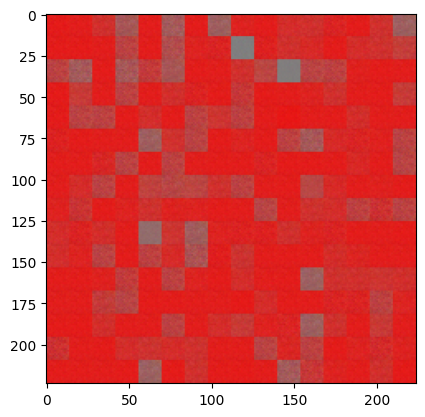

In [36]:
plt.imshow(denoised_[0].permute(1,2,0).detach().numpy())